In [36]:
import utils
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape,Input,TimeDistributed,GRU
from keras.regularizers import L1, L2, L1L2
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [37]:
# Load the Dataset

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

y_train_valid -= 769
y_test -= 769


(2115, 22, 1000)


In [38]:
ind_valid = np.random.choice(2115, 200, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

# Shuffle the data after adding the noise to them so that the noisy examples 
# are not all together
x_train, y_train = utils.addNoisyExamplesToData(x_train, y_train, 3000, 0, 1)

indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]
print(x_train.shape)
print(y_train.shape)

y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)

# Reshape so that each example is three-dimensional 
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Axis swapping so that the channel is the last dimension
x_train = np.swapaxes(x_train, 1, 3)
x_train = np.swapaxes(x_train, 1, 2)
x_valid = np.swapaxes(x_valid, 1, 3)
x_valid = np.swapaxes(x_valid, 1, 2)
X_test = np.swapaxes(X_test, 1, 3)
X_test = np.swapaxes(X_test, 1, 2)

x_train = x_train[:, 0:600, :, :]
x_valid = x_valid[:, 0:600, :, :]
X_test = X_test[:, 0:600, :, :]
print(x_train.shape)

(4915, 22, 1000)
(4915,)
(4915, 600, 1, 22)


# LSTM

In [45]:
rnn_model = Sequential()

rnn_model.add(Input((600, 1, 22)))

rnn_model.add(TimeDistributed(Flatten()))
rnn_model.add(TimeDistributed(Dense(20, activation='relu', kernel_regularizer=L1L2(l1=0.01, l2=0.01))))
rnn_model.add(TimeDistributed(Dropout(0.6)))
rnn_model.add(TimeDistributed(BatchNormalization()))

rnn_model.add(LSTM(8, dropout=0.6, recurrent_dropout=0.2, kernel_regularizer=L1(0.01), return_sequences=True))

rnn_model.add(Flatten())
rnn_model.add(Dense(4, activation='softmax'))

rnn_model.summary()


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_64 (TimeD  (None, 600, 22)           0         
 istributed)                                                     
                                                                 
 time_distributed_65 (TimeD  (None, 600, 20)           460       
 istributed)                                                     
                                                                 
 time_distributed_66 (TimeD  (None, 600, 20)           0         
 istributed)                                                     
                                                                 
 time_distributed_67 (TimeD  (None, 600, 20)           80        
 istributed)                                                     
                                                                 
 lstm_12 (LSTM)              (None, 600, 8)          

In [46]:
# Model parameters
learning_rate = 1e-3
epochs = 100
rnn_optimizer = keras.optimizers.legacy.Adam(learning_rate=learning_rate)

In [47]:
# Compiling the model
rnn_model.compile(loss='categorical_crossentropy',
                 optimizer=rnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
rnn_model_results = rnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)


Epoch 1/100
77/77 [==============================] - 13s 162ms/step - loss: 3.1145 - accuracy: 0.3622 - val_loss: 2.9398 - val_accuracy: 0.3400
Epoch 2/100
77/77 [==============================] - 12s 161ms/step - loss: 2.4095 - accuracy: 0.4824 - val_loss: 2.3281 - val_accuracy: 0.4750
Epoch 3/100
77/77 [==============================] - 12s 161ms/step - loss: 1.9145 - accuracy: 0.5626 - val_loss: 1.9393 - val_accuracy: 0.4600
Epoch 4/100
77/77 [==============================] - 12s 161ms/step - loss: 1.5702 - accuracy: 0.6205 - val_loss: 1.7619 - val_accuracy: 0.4250
Epoch 5/100
77/77 [==============================] - 13s 163ms/step - loss: 1.3594 - accuracy: 0.6378 - val_loss: 1.5777 - val_accuracy: 0.4850
Epoch 6/100
77/77 [==============================] - 13s 162ms/step - loss: 1.2420 - accuracy: 0.6675 - val_loss: 1.5104 - val_accuracy: 0.5450
Epoch 7/100
77/77 [==============================] - 12s 162ms/step - loss: 1.1735 - accuracy: 0.6761 - val_loss: 1.4404 - val_accuracy:

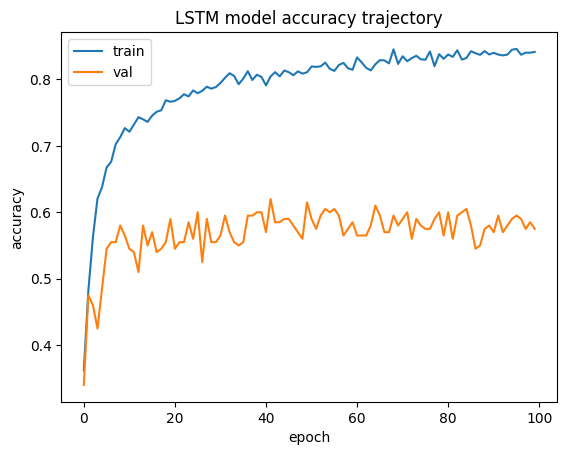

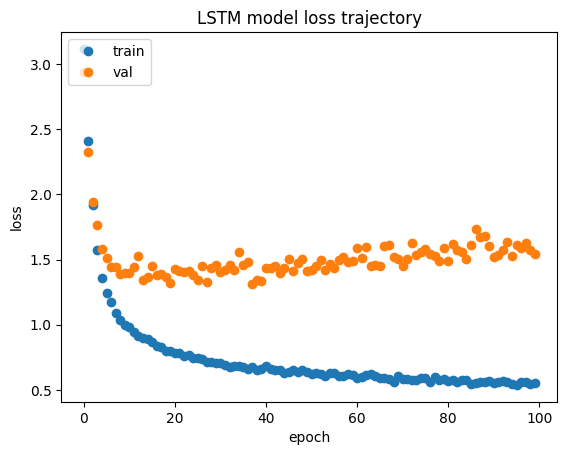

In [54]:
# Plotting accuracy trajectory
plt.plot(rnn_model_results.history['accuracy'])
plt.plot(rnn_model_results.history['val_accuracy'])
plt.title('LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(rnn_model_results.history['loss'],'o')
plt.plot(rnn_model_results.history['val_loss'],'o')
plt.title('LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [55]:
rnn_model_score_all_subjects = rnn_model.evaluate(X_test[:, 0:600, :, :], y_test, verbose=0)
print("Accuracy Across All Subjects: {score}".format(score=rnn_model_score_all_subjects[1]))

Accuracy Across All Subjects: 0.6004514694213867


# GRU

In [51]:
rnn_model_2 = Sequential()

rnn_model_2.add(Input((600, 1, 22)))

rnn_model_2.add(TimeDistributed(Flatten()))
rnn_model_2.add(TimeDistributed(Dense(20, activation='relu', kernel_regularizer=L1L2(l1=0.01, l2=0.01))))
rnn_model_2.add(TimeDistributed(Dropout(0.6)))
rnn_model_2.add(TimeDistributed(BatchNormalization()))

rnn_model_2.add(GRU(8, dropout=0.6, recurrent_dropout=0.2, kernel_regularizer=L1(0.01), return_sequences=True))

rnn_model_2.add(Flatten())
rnn_model_2.add(Dense(4, activation='softmax'))

rnn_model_2.summary()


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_72 (TimeD  (None, 600, 22)           0         
 istributed)                                                     
                                                                 
 time_distributed_73 (TimeD  (None, 600, 20)           460       
 istributed)                                                     
                                                                 
 time_distributed_74 (TimeD  (None, 600, 20)           0         
 istributed)                                                     
                                                                 
 time_distributed_75 (TimeD  (None, 600, 20)           80        
 istributed)                                                     
                                                                 
 gru (GRU)                   (None, 600, 8)          

In [52]:
# Model parameters
learning_rate = 1e-3
epochs = 100
rnn_optimizer_2 = keras.optimizers.legacy.Adam(learning_rate=learning_rate)

In [53]:
# Compiling the model
rnn_model_2.compile(loss='categorical_crossentropy',
                 optimizer=rnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
rnn_model_2_results = rnn_model_2.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)


Epoch 1/100
77/77 [==============================] - 14s 151ms/step - loss: 2.4742 - accuracy: 0.3967 - val_loss: 1.9739 - val_accuracy: 0.4250
Epoch 2/100
77/77 [==============================] - 11s 147ms/step - loss: 1.5110 - accuracy: 0.5577 - val_loss: 1.6044 - val_accuracy: 0.4350
Epoch 3/100
77/77 [==============================] - 11s 144ms/step - loss: 1.2479 - accuracy: 0.6232 - val_loss: 1.4984 - val_accuracy: 0.4550
Epoch 4/100
77/77 [==============================] - 11s 144ms/step - loss: 1.1519 - accuracy: 0.6395 - val_loss: 1.4751 - val_accuracy: 0.4650
Epoch 5/100
77/77 [==============================] - 11s 146ms/step - loss: 1.0607 - accuracy: 0.6781 - val_loss: 1.3697 - val_accuracy: 0.4550
Epoch 6/100
77/77 [==============================] - 11s 144ms/step - loss: 1.0183 - accuracy: 0.6804 - val_loss: 1.3979 - val_accuracy: 0.5100
Epoch 7/100
77/77 [==============================] - 11s 144ms/step - loss: 0.9790 - accuracy: 0.6916 - val_loss: 1.4933 - val_accuracy:

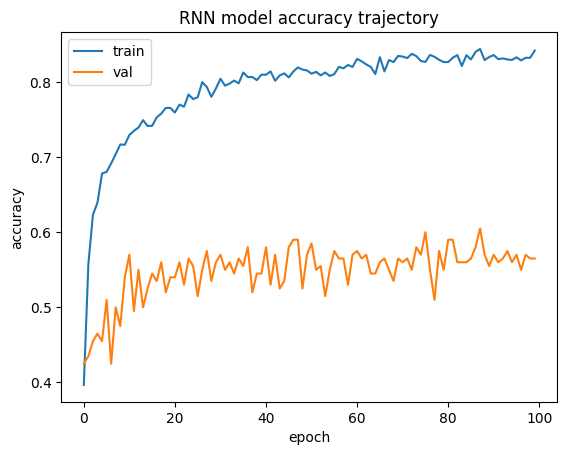

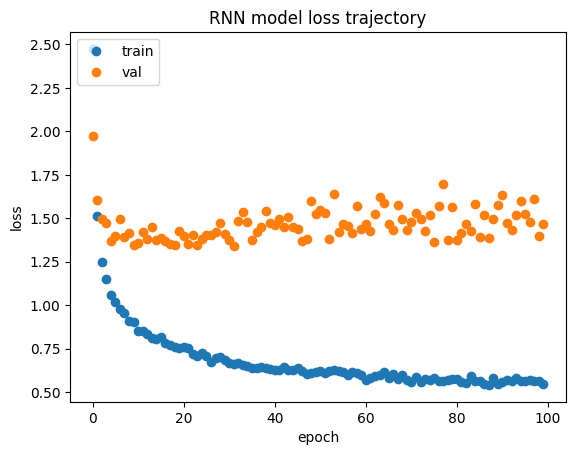

In [56]:
# Plotting accuracy trajectory
plt.plot(rnn_model_2_results.history['accuracy'])
plt.plot(rnn_model_2_results.history['val_accuracy'])
plt.title('RNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(rnn_model_2_results.history['loss'],'o')
plt.plot(rnn_model_2_results.history['val_loss'],'o')
plt.title('RNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [58]:
rnn_model_2_score_all_subjects = rnn_model_2.evaluate(X_test[:, 0:600, :, :], y_test, verbose=0)
print("Accuracy Across All Subjects: {score}".format(score=rnn_model_2_score_all_subjects[1]))

Accuracy Across All Subjects: 0.5575620532035828
